In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define the data directory
test_dir = '../dataset/DevanagariHandwrittenCharacterDataset/test'
train_dir = '../dataset/DevanagariHandwrittenCharacterDataset/train'

# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the dataset
testset = ImageFolder(test_dir, transform=transform)
trainset = ImageFolder(train_dir, transform=transform)

# Create a dataloader
batch_size = 64
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

cuda:0


torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
tensor(8)


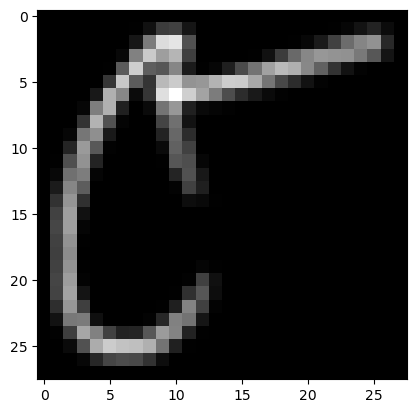

In [2]:
# Get iterator object
data_iter = iter(testloader)

# Get a batch of data
images, labels = next(data_iter)

# Get a single image
single_image = images[0]

print(single_image.shape)

newimg = torch.permute(single_image, (1,2,0))

print(newimg.shape)

plt.imshow(newimg, cmap="gray")
print(labels[0])

In [3]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

In [40]:
# Instantiate the model
model = Net()
model.to(device)
model.load_state_dict(torch.load('mnist_model_99_30.pt'))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.048, momentum=0.5)

for name, weight in model.named_parameters():
    print(name)
    if(("fc" in name) or ("conv2" in name)):
        weight.requires_grad = True
    else:
        weight.requires_grad = False

from torchinfo import summary

summary(model)

# print(model)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            (320)
├─Conv2d: 1-2                            18,496
├─Dropout2d: 1-3                         --
├─Dropout2d: 1-4                         --
├─Linear: 1-5                            1,179,776
├─Linear: 1-6                            1,290
Total params: 1,199,882
Trainable params: 1,199,562
Non-trainable params: 320

In [41]:
# Evaluate the model on the test data
test_loss = 0.0
test_correct = 0
model.eval()
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = output.to(device)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        test_correct += (predicted == target).sum().item()
test_loss /= len(testloader.dataset)
test_accuracy = 100.0 * test_correct / len(testloader.dataset)
print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 9.7117, Test Accuracy: 25.17%


In [42]:
# Train the model
epochs = 30
Best_Train = -1
Best_Epoch = -1
for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
    train_loss /= len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / len(trainloader.dataset)
    if(train_accuracy>Best_Train):
        Best_Train = train_accuracy
        Best_Epoch = epoch+1
    print('Epoch: {}, Training Loss: {:.4f}, Training Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, train_accuracy))

print(f"Best Training Accuracy: {Best_Train} at Epoch: {Best_Epoch}")

Epoch: 1, Training Loss: 0.5940, Training Accuracy: 83.10%
Epoch: 2, Training Loss: 0.1702, Training Accuracy: 94.92%
Epoch: 3, Training Loss: 0.1098, Training Accuracy: 96.53%
Epoch: 4, Training Loss: 0.0835, Training Accuracy: 97.44%
Epoch: 5, Training Loss: 0.0686, Training Accuracy: 98.04%
Epoch: 6, Training Loss: 0.0557, Training Accuracy: 98.14%
Epoch: 7, Training Loss: 0.0461, Training Accuracy: 98.55%
Epoch: 8, Training Loss: 0.0435, Training Accuracy: 98.59%
Epoch: 9, Training Loss: 0.0365, Training Accuracy: 98.84%
Epoch: 10, Training Loss: 0.0333, Training Accuracy: 99.01%
Epoch: 11, Training Loss: 0.0266, Training Accuracy: 99.17%
Epoch: 12, Training Loss: 0.0276, Training Accuracy: 99.16%
Epoch: 13, Training Loss: 0.0259, Training Accuracy: 99.13%
Epoch: 14, Training Loss: 0.0247, Training Accuracy: 99.29%
Epoch: 15, Training Loss: 0.0214, Training Accuracy: 99.35%
Epoch: 16, Training Loss: 0.0236, Training Accuracy: 99.29%
Epoch: 17, Training Loss: 0.0196, Training Accura

In [43]:
# Evaluate the model on the test data
test_loss = 0.0
test_correct = 0
model.eval()
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = output.to(device)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        test_correct += (predicted == target).sum().item()
test_loss /= len(testloader.dataset)
test_accuracy = 100.0 * test_correct / len(testloader.dataset)
print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 0.0211, Test Accuracy: 99.57%


In [30]:
torch.save(model.state_dict(), "devanagiri_weights_99_67")